In [1]:
#Importing Packages
import numpy as np
import xarray as xr
from tinygp import kernels, GaussianProcess
import jax
from jax import random
import matplotlib.pyplot as plt
import arviz as az
from src.model_fitting_functions import run_inference
from src.examples_functions import tinygp_2process_model,truth_posterior_predictive,bias_posterior_predictive,posterior_predictive_realisations

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [2]:
#Creating Underlying Process Data 

X1 = np.arange(0,105,2)
X2 = np.arange(0,105,2)

ds = xr.Dataset(
    coords=dict(
        X1=("X1", X1),
        X2=("X2", X2),
    ),
)

ds_stacked = ds.stack(X=('X1', 'X2'))
X = np.array(list(map(np.array, ds_stacked.X.data)))

# #Truth
GP = GaussianProcess(1 * kernels.ExpSquared(10),X,diag=1e-5,mean=1.0)
Y = GP.sample(rng_key)

#Bias
GP2 = GaussianProcess(1 * kernels.ExpSquared(40),X,diag=1e-5,mean=-1.0)
rng_key, rng_key_ = random.split(rng_key)
Y2 = GP2.sample(rng_key)

ds_stacked["Y"]=(['X'],  Y)
ds_stacked["Y2"]=(['X'],  Y2)
ds_stacked["Y3"]=(['X'],  Y+Y2)

ds = ds_stacked.unstack()

In [3]:
#Observations
da_obs = ds.Y.isel(X1=slice(1,None,5),X2=slice(1,None,5))
X1_condition = (ds.X1<25) | (ds.X1>75) 
X2_condition = (ds.X2<25) | (ds.X2>75) 
da_obs = da_obs.where(X1_condition|X2_condition,drop=True)
da_obs_stacked = da_obs.stack(X=('X1', 'X2'))

#Climate model
da_climate = ds.Y3.isel(X1=slice(None,None,5),X2=slice(None,None,5))
da_climate_stacked = da_climate.stack(X=('X1', 'X2'))

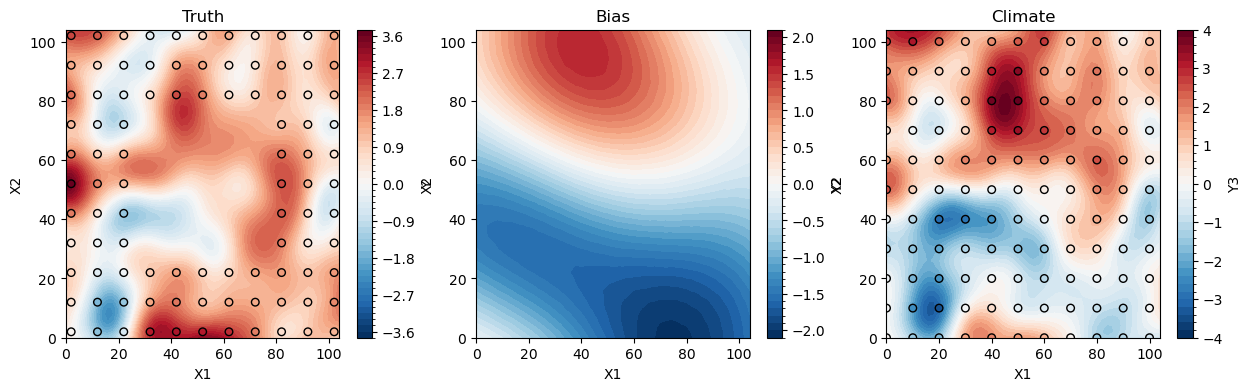

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plots = []
variables = ['Y','Y2','Y3']
titles = ['Truth','Bias','Climate']
# vmin = min(ds.min().data_vars.values())
# vmax = max(ds.max().data_vars.values())

for i,var,title in zip(range(1, 4), variables, titles):
    plt.subplot(1, 3, i)
    plots.append(
        ds[f'{var}'].plot.contourf(x='X1',y='X2',levels=50)
    )
    plt.title(title)

for i,var,da in zip([0,2],['Y','Y3'],[da_obs,da_climate]):
    ax = axs.flatten()[i]
    da.to_dataset().plot.scatter(x='X1',y='X2',hue=f'{var}',s=30, edgecolors='k',add_colorbar=False, ax=ax, add_title=False)
# https://docs.xarray.dev/en/stable/generated/xarray.plot.scatter.html

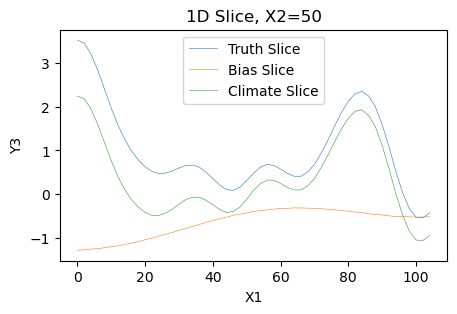

In [5]:
plt.figure(figsize=(5,3))
val = 50
ds['Y'].sel(X2=val).plot(label='Truth Slice')
ds['Y2'].sel(X2=val).plot(label='Bias Slice')
ds['Y3'].sel(X2=val).plot(label='Climate Slice')
plt.legend()
plt.title(f'1D Slice, X2={val}')
plt.show()

In [6]:
odata = da_obs_stacked.dropna('X').data
ox = np.array(list(map(np.array, da_obs_stacked.dropna('X').X.data)))
cdata = da_climate_stacked.data
cx = np.array(list(map(np.array, da_climate_stacked.X.data)))

In [7]:
mcmc_2process = run_inference(tinygp_2process_model, rng_key_, 1000, 2000, cx,cdata=cdata,ox=ox,odata=odata,noise=1e-5)

sample: 100%|██████████| 3000/3000 [12:52<00:00,  3.88it/s, 7 steps of size 3.99e-01. acc. prob=0.86]    



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     bkern_var      4.41      2.95      3.64      0.67      8.45    931.48      1.00
  blengthscale     99.92    124.38     63.86     14.37    204.00    789.09      1.00
         bmean     -0.11      1.14     -0.17     -1.75      1.97   1772.80      1.00
      kern_var      1.08      0.17      1.07      0.81      1.36    783.61      1.00
   lengthscale      9.58      0.29      9.59      9.11     10.05    699.50      1.00
          mean      1.03      0.21      1.03      0.70      1.37   1445.17      1.00

Number of divergences: 1
Time Taken: 777.3182189539075


In [8]:
#Saving Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Examples_Output/'
idata_2process = az.from_numpyro(mcmc_2process)
idata_2process.to_netcdf(f'{outfile_dir}idata_2process_2d.nc')

'/home/jez/Bias_Correction/data/Examples_Output/idata_2process_2d.nc'

In [9]:
#Loading Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Examples_Output/'
idata_2process = az.from_netcdf(f'{outfile_dir}idata_2process_2d.nc')

In [10]:
#Realisations
ds_predictions = ds.isel(X1=slice(None,None,2),X2=slice(None,None,2))
ds_predictions_stacked = ds_predictions.stack(X=('X1', 'X2'))
nx = np.array(list(map(np.array, ds_predictions_stacked.X.data)))

num_parameter_realisations = 20
num_posterior_pred_realisations = 20

truth_realisations = posterior_predictive_realisations(truth_posterior_predictive,nx,ox,cx,odata,cdata,idata_2process,num_parameter_realisations,num_posterior_pred_realisations)
bias_realisations = posterior_predictive_realisations(bias_posterior_predictive,nx,ox,cx,odata,cdata,idata_2process,num_parameter_realisations,num_posterior_pred_realisations)


ds_predictions_stacked["mean_truth"]=(['X'],  truth_realisations.mean(axis=(0,1)))
ds_predictions_stacked["std_truth"]=(['X'],  truth_realisations.std(axis=(0,1)))
ds_predictions_stacked["mean_bias"]=(['X'],  bias_realisations.mean(axis=(0,1)))
ds_predictions_stacked["std_bias"]=(['X'],  bias_realisations.std(axis=(0,1)))

ds_predictions = ds_predictions_stacked.unstack()

100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


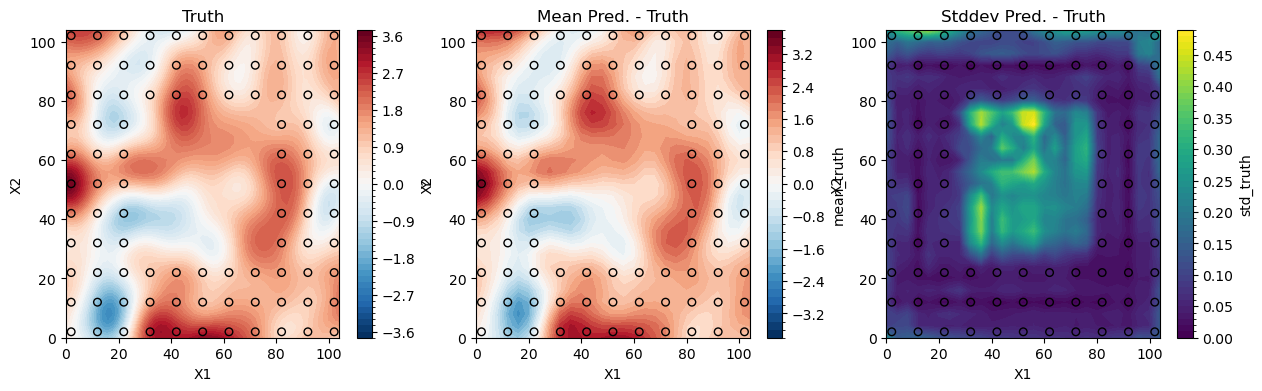

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plots = []
variables = ['mean_truth','std_truth']
titles = ['Mean Pred. - Truth','Stddev Pred. - Truth']

plt.subplot(1, 3, 1)
plots.append(ds['Y'].plot.contourf(x='X1',y='X2',levels=50,ax=axs.flatten()[0]))
plt.title('Truth')

for i,var,title in zip(range(2, 4), variables, titles):
    plt.subplot(1, 3, i)
    plots.append(
        ds_predictions[f'{var}'].plot.contourf(x='X1',y='X2',levels=50)
    )
    plt.title(title)

for i in [0,1,2]:
    ax = axs.flatten()[i]
    da_obs_stacked.dropna('X').to_dataset().plot.scatter(x='X1',y='X2',hue=None,s=30, edgecolors='k',add_colorbar=False, ax=ax, add_title=False,facecolors="none")
# https://docs.xarray.dev/en/stable/generated/xarray.plot.scatter.html

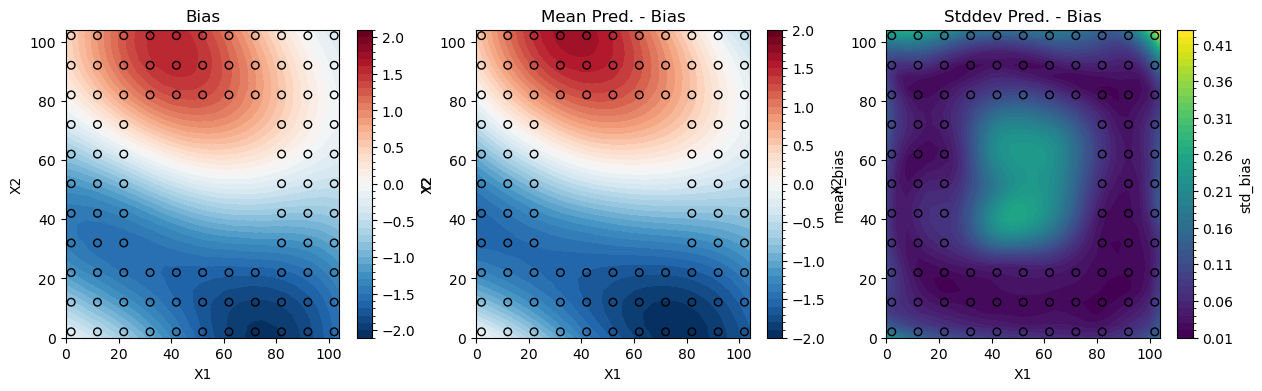

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plots = []
variables = ['mean_bias','std_bias']
titles = ['Mean Pred. - Bias','Stddev Pred. - Bias']

plt.subplot(1, 3, 1)
plots.append(ds['Y2'].plot.contourf(x='X1',y='X2',levels=50,ax=axs.flatten()[0]))
plt.title('Bias')

for i,var,title in zip(range(2, 4), variables, titles):
    plt.subplot(1, 3, i)
    plots.append(
        ds_predictions[f'{var}'].plot.contourf(x='X1',y='X2',levels=50)
    )
    plt.title(title)

for i in [0,1,2]:
    ax = axs.flatten()[i]
    da_obs_stacked.dropna('X').to_dataset().plot.scatter(x='X1',y='X2',hue=None,s=30, edgecolors='k',add_colorbar=False, ax=ax, add_title=False,facecolors="none")
# https://docs.xarray.dev/en/stable/generated/xarray.plot.scatter.html

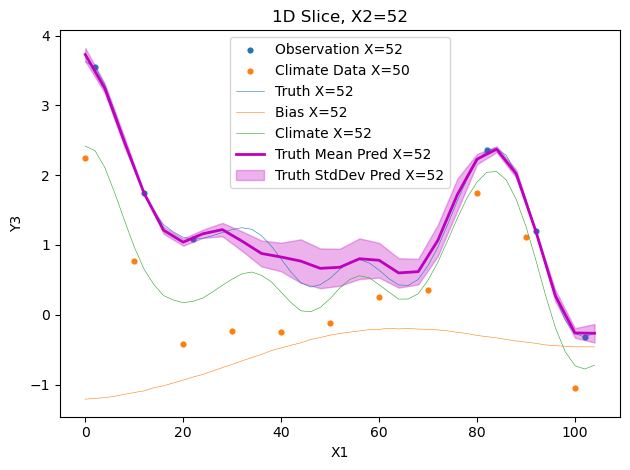

In [13]:
val = 52

da_obs_slice=da_obs.sel(X2=val)
da_obs_slice.to_dataset().plot.scatter(x='X1',y='Y',s=30,label=f'Observation X={val}')
da_climate_slice=da_climate.sel(X2=val,method="nearest")
da_climate_slice.to_dataset().plot.scatter(x='X1',y='Y3',s=30,label=f'Climate Data X={da_climate_slice.X2.data}')

ds_slice = ds.sel(X2=val)

ds_slice['Y'].plot(label = f'Truth X={val}')
ds_slice['Y2'].plot(label = f'Bias X={val}')
ds_slice['Y3'].plot(label = f'Climate X={val}')

ds_predictions_slice = ds_predictions.sel(X2=val)
x_slice = ds_predictions_slice.X1.data
truth_pred_mean = ds_predictions_slice['mean_truth'].data
truth_pred_std = ds_predictions_slice['std_truth'].data
plt.plot(x_slice,truth_pred_mean,label=f'Truth Mean Pred X={val}',color='m',alpha=1.0,linewidth=2)
plt.fill_between(x_slice,truth_pred_mean+truth_pred_std,truth_pred_mean-truth_pred_std,label=f'Truth StdDev Pred X={val}',color='m',alpha=0.3)

plt.title(f'1D Slice, X2={val}')
plt.legend()
plt.tight_layout()